In [12]:
import math
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
DEBUG = True

In [2]:
# Break up data into consecutive groups.
def consecutive_groups(x, stepsize=1):
    return [ i for i in range(1, len(x), stepsize) if x[i] != x[i-1] ]

In [3]:
def getangle(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    return np.rad2deg(np.arctan2(y2 - y1, x2 - x1))

In [4]:
def getangle_lines(eroded):
    angles = []
    height, width = np.shape(eroded)

    # Make np array and transposed to process vertical and horizontal lines.
    a = np.array(eroded)
    b = np.transpose(a)

    for x in [a, b]:
        multiplier = 1 if len(x[0]) == width else -1 # 1 for normal, -1 for transposed.
        top = consecutive_groups(x[0])
        bottom = consecutive_groups(x[-1])

        # Only look at the first and last pair.
        for i in [0, 1, -2, -1]:
            print(getangle((top[i], 0), (bottom[i], len(x)))) if DEBUG and top and bottom else None
            angle = multiplier * (getangle((top[i], 0), (bottom[i], len(x))) - 90) if top and bottom else 0
            # Only take angles < 2 degrees.
            angles.append(angle) if abs(angle) < 2 else None

    avg_angle = sum(angles)/len(angles)

    print(angles) if DEBUG else None
    print(avg_angle) if DEBUG else None
    return avg_angle

In [5]:
def rotate_image(img, angle):
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img.copy(), M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

In [117]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

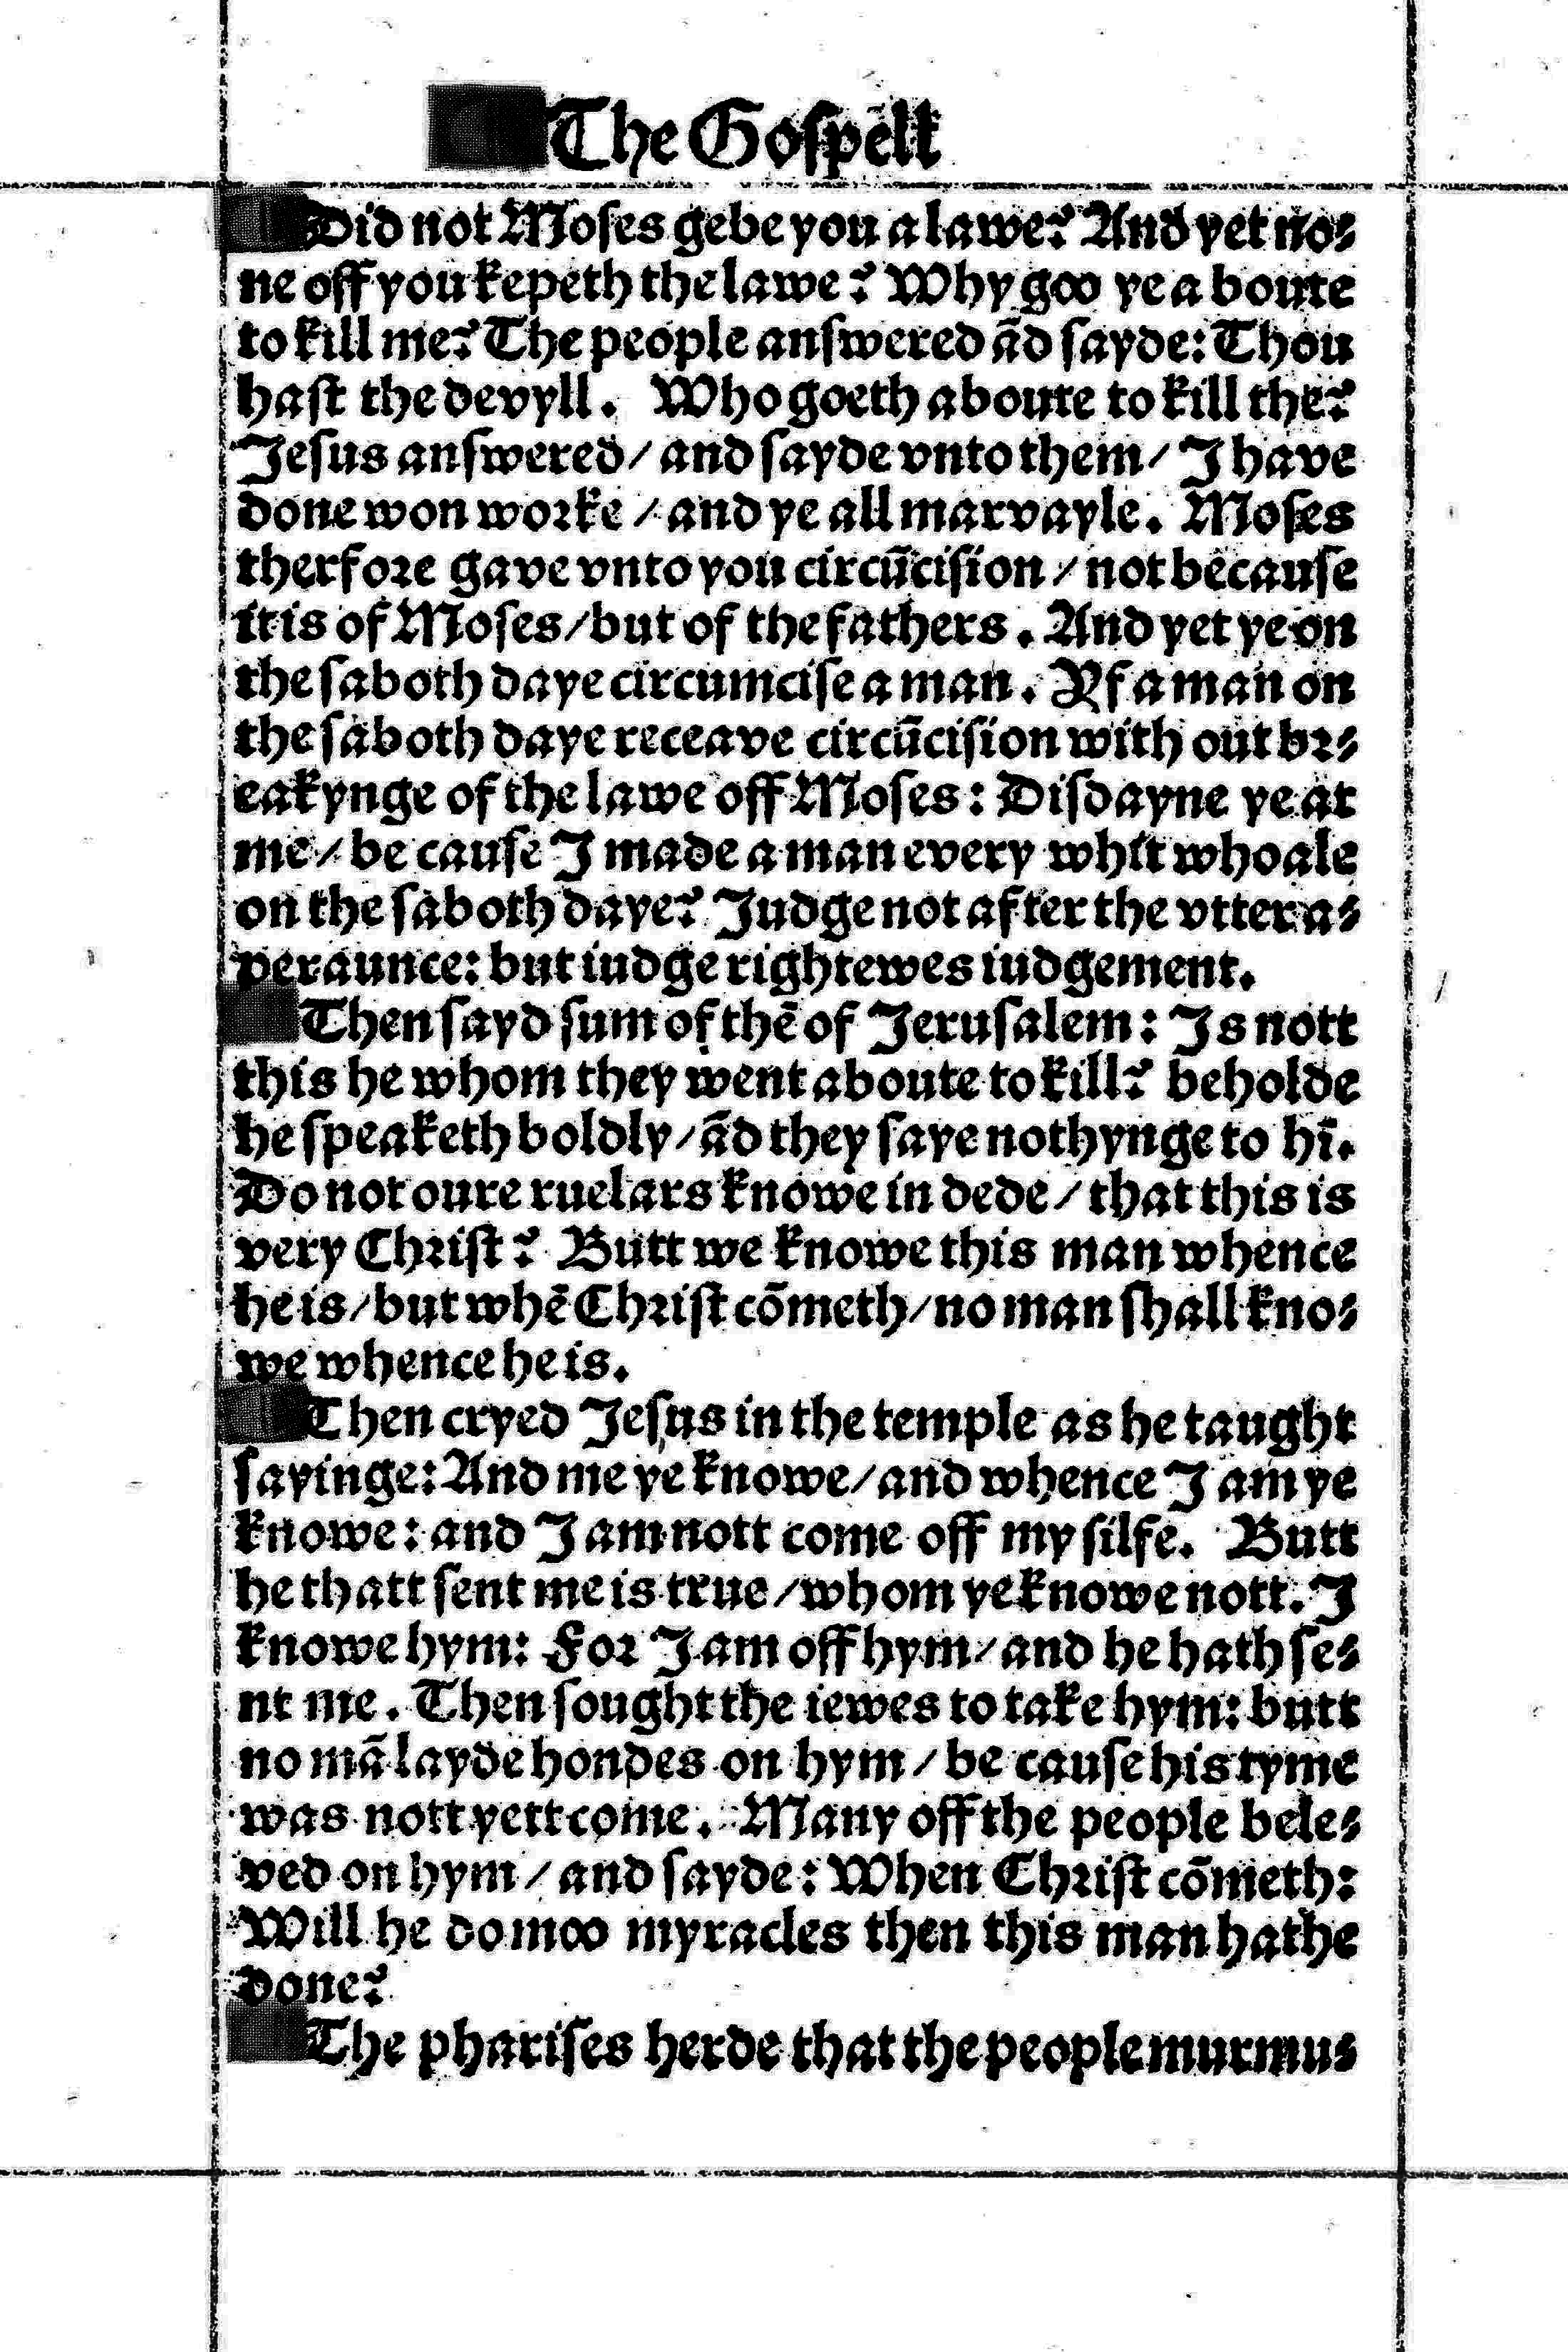

In [124]:
img = cv2.imread('4.rotated/john0024.jpg', cv2.IMREAD_GRAYSCALE)
img = adjust_gamma(img, 0.1)
Image.fromarray(img)

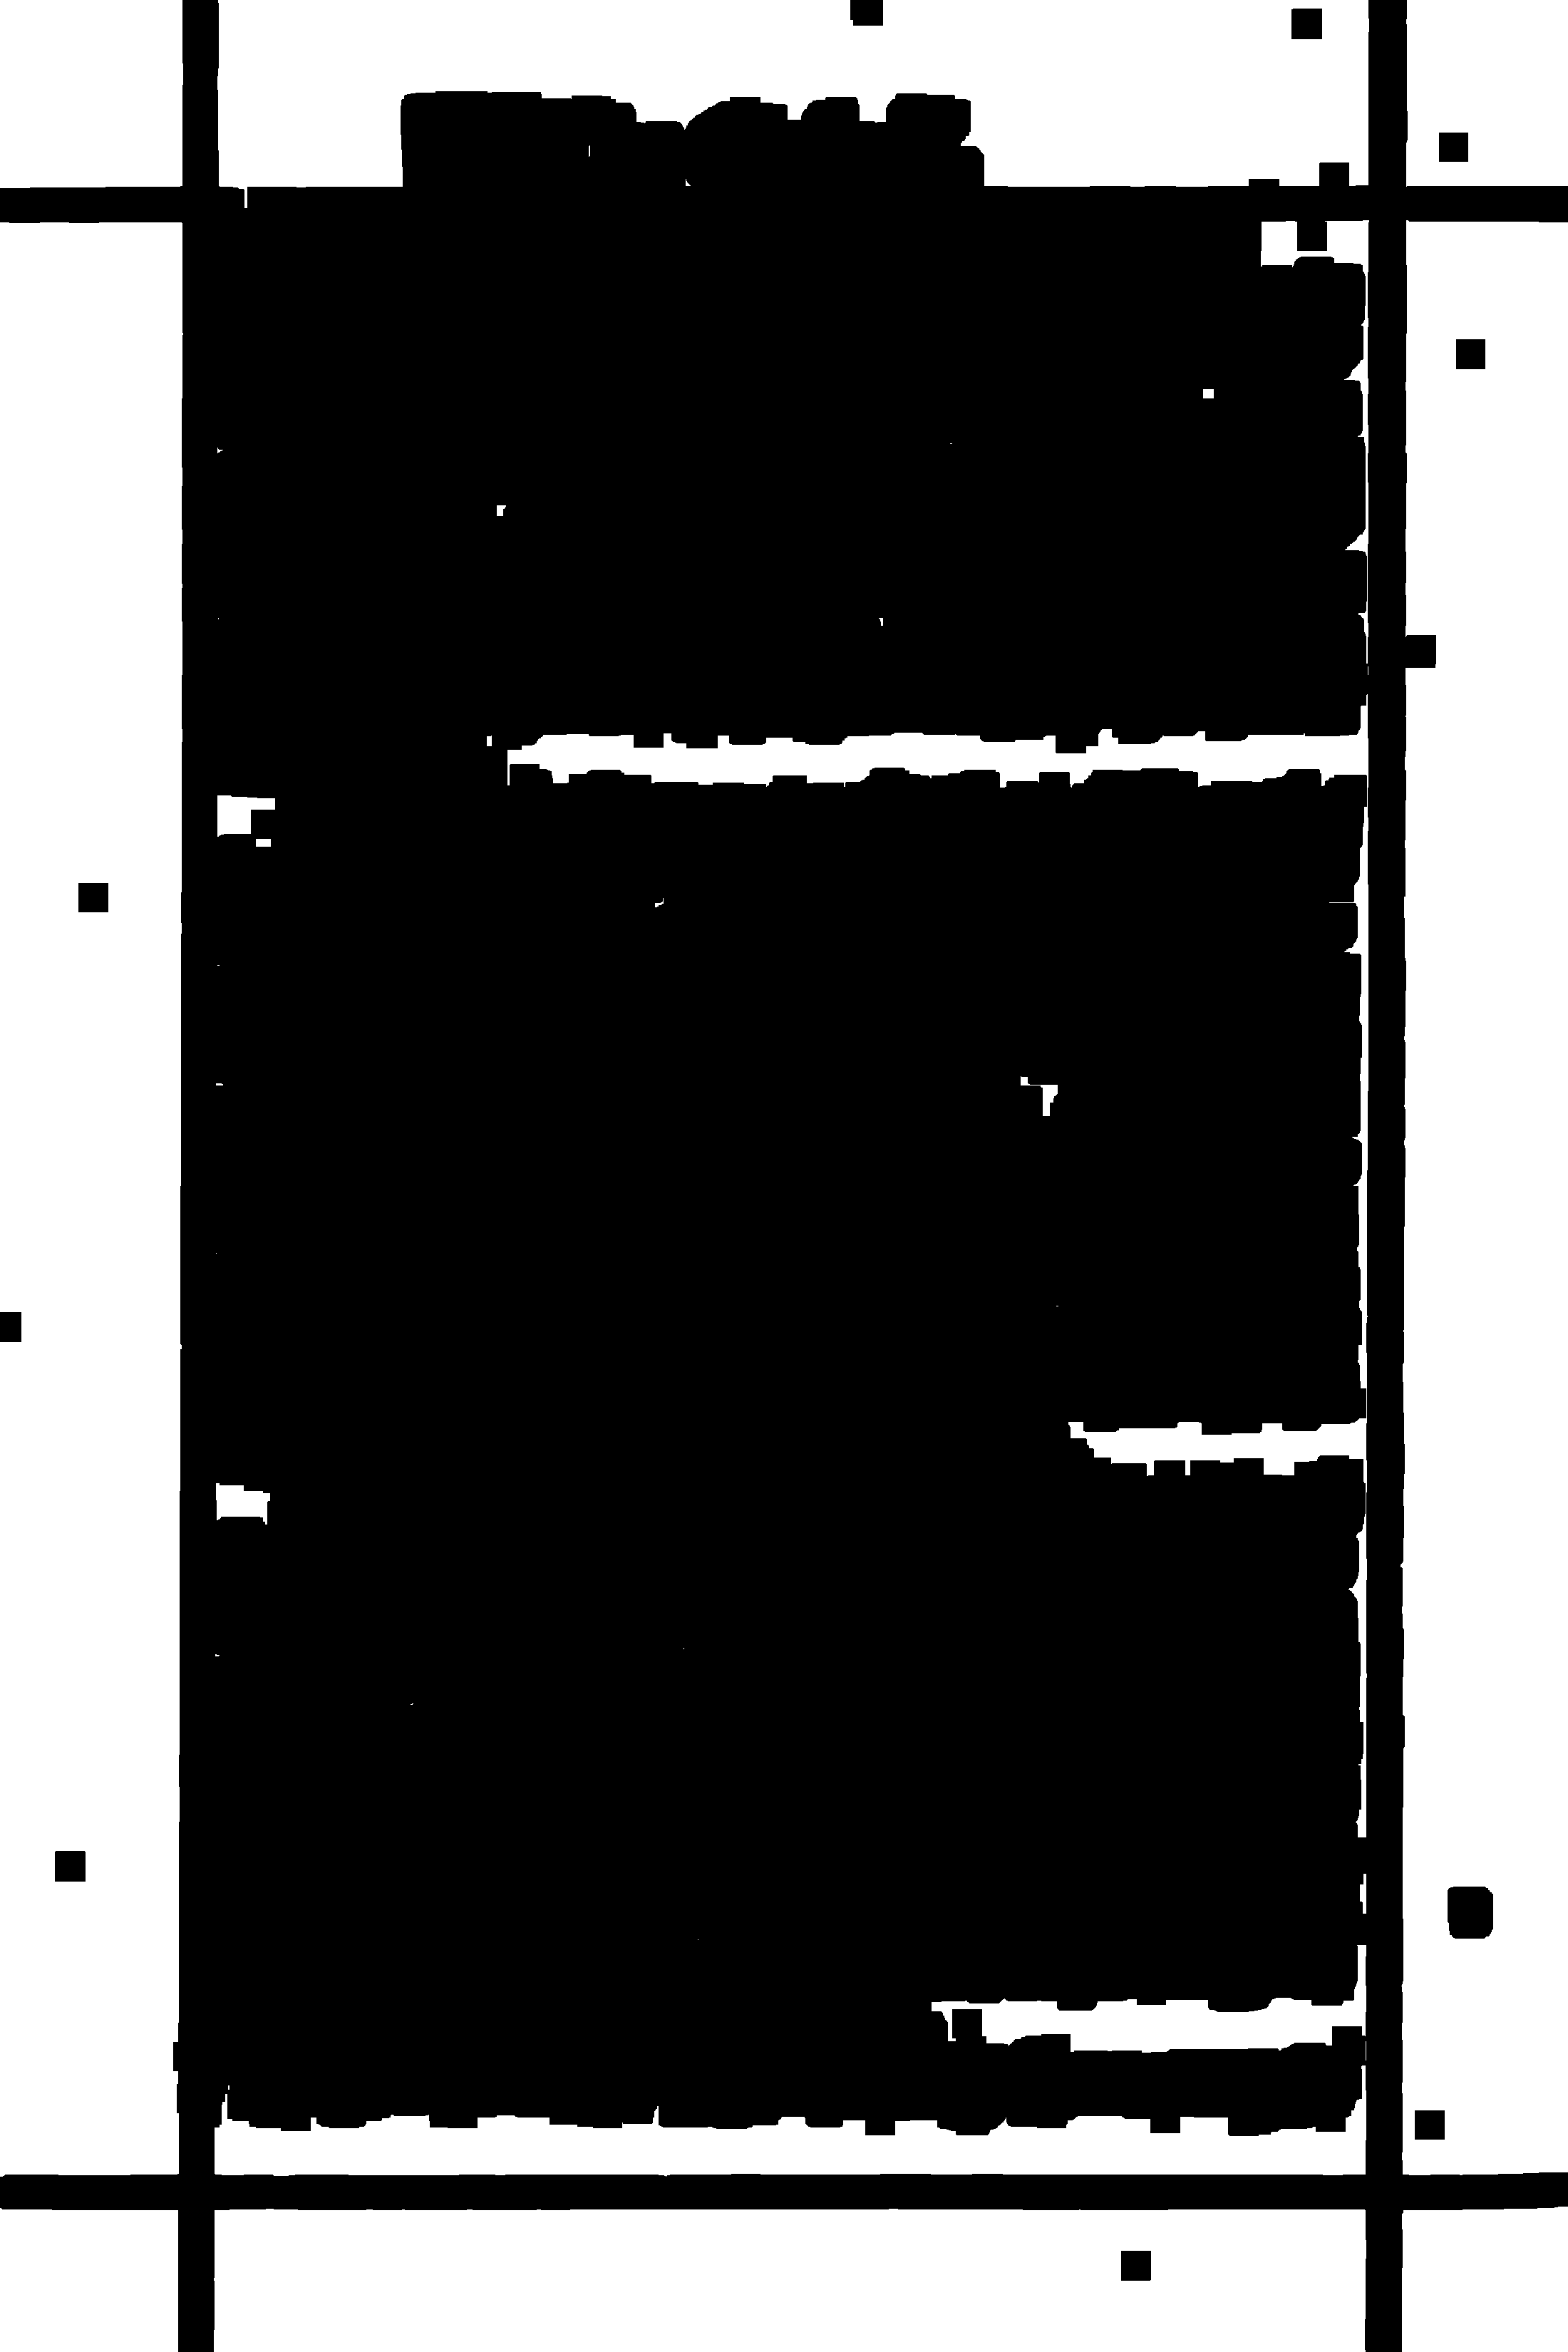

In [131]:
img = cv2.imread('4.rotated/john0002.jpg', cv2.IMREAD_GRAYSCALE)

img = adjust_gamma(img, 0.5)

ksize = 5
kernel_size = (ksize, ksize)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
erosion_iterations = 10

ret, thresh = cv2.threshold(img.copy(), 127, 255, cv2.THRESH_BINARY)
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
eroded = cv2.erode(thresh, kernel, iterations = erosion_iterations)
Image.fromarray(eroded) if DEBUG else None

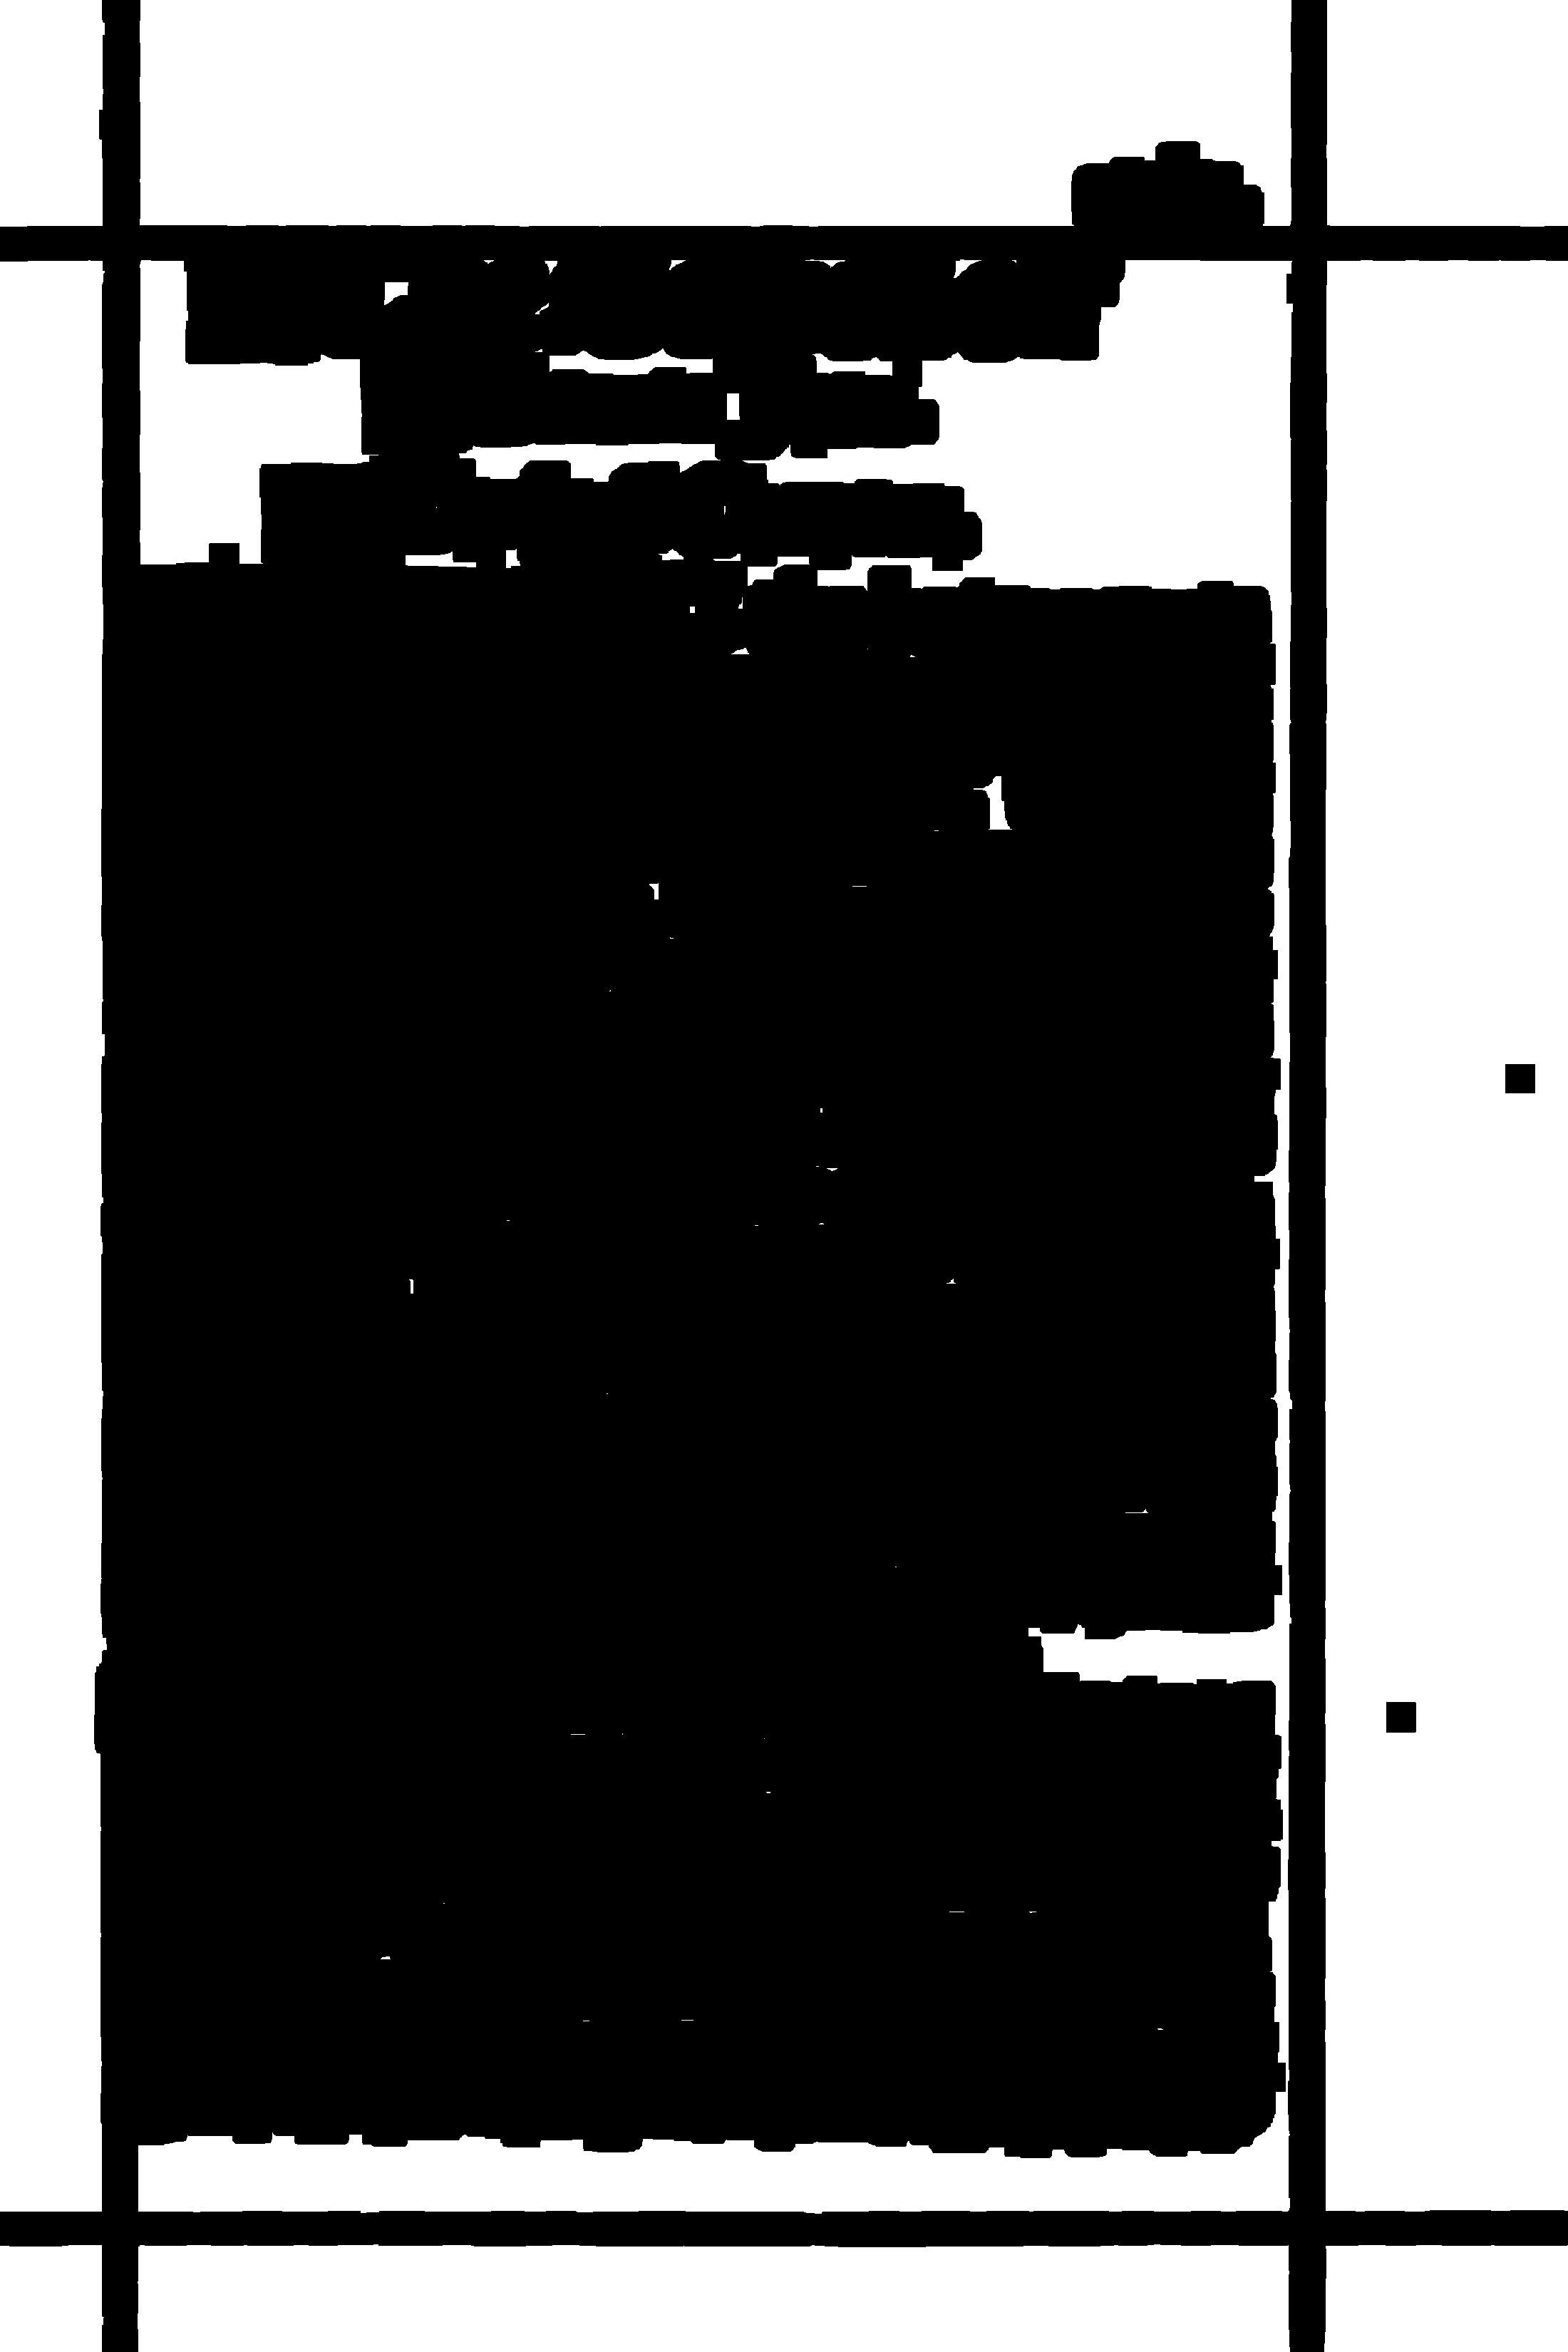

In [141]:
eroded = cv2.imread('5.eroded/john0001.jpg', cv2.IMREAD_GRAYSCALE)
Image.fromarray(eroded)

In [140]:
print(consecutive_groups(eroded[0]))
print(consecutive_groups(np.transpose(eroded)[0]))

[137, 138, 140, 141, 142, 143, 144, 192, 193, 194, 196, 197, 198, 199, 200, 1808, 1810, 1812, 1857, 1858, 1859, 1860, 1862, 1863, 1864]
[314, 315, 316, 317, 318, 319, 320, 362, 363, 365, 366, 367, 3098, 3099, 3101, 3102, 3103, 3146, 3147, 3149, 3150, 3151]


In [133]:
ksize = 5
kernel_size = (ksize, ksize)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
erosion_iterations = 10

linewidth = []
cropwidth = []
cropheight = []

for f in range(1, 70):    
    filename = "john{:04d}.jpg".format(f)
    inpath = "4.rotated/{}".format(filename)
    outpath = "5.eroded/{}".format(filename)
    
    img = cv2.imread(inpath, cv2.IMREAD_GRAYSCALE)
    img = adjust_gamma(img, 0.5)
    ret, thresh = cv2.threshold(img.copy(), 127, 255, cv2.THRESH_BINARY)
    eroded = cv2.erode(thresh, kernel, iterations = erosion_iterations)
    
#     y = Image.fromarray(eroded)
#     y.save(outpath)
#     print(outpath)

    horizontal = consecutive_groups(eroded[0])
    vertical = consecutive_groups(np.transpose(eroded)[0])

    img = cv2.imread(inpath)
    if len(horizontal) >= 4 and len(vertical) >= 4:
        l1, l2, r1, r2 = horizontal[:2] + horizontal[-2:]
        t1, t2, b1, b2 = vertical[:2] + vertical[-2:]

        for w in [l2-l1, r2-r1, t2-t1, b2-b1]:
            linewidth.append(w)
        cropwidth.append(r2-l1)
        cropheight.append(b2-t1)
        
        print(filename, horizontal, vertical)

    elif len(horizontal) == 0 or len(vertical) == 0:
        print(filename)
    else:
        print(filename, horizontal, vertical)


print('linewidth: {}'.format(sorted(linewidth)))
print('cropwidth: {}'.format(sorted(cropwidth)))
print('cropheight: {}'.format(sorted(cropheight)))
print(min(linewidth), max(linewidth), min(cropwidth), max(cropwidth), min(cropheight), max(cropheight))

5.eroded/john0001.jpg
john0001.jpg [143, 197, 1812, 1862] [318, 367, 3103, 3151]
5.eroded/john0002.jpg
john0002.jpg [256, 306, 1193, 1239, 1920, 1974] [264, 312, 1841, 1883, 3054, 3098]
5.eroded/john0003.jpg
john0003.jpg [172, 227, 1841, 1892] [311, 361, 2613, 2658, 3099, 3147]
5.eroded/john0004.jpg
john0004.jpg [252, 302, 355, 396, 1918, 1969] [249, 296, 3037, 3082]
5.eroded/john0005.jpg
john0005.jpg [36, 77, 148, 197, 1813, 1859] [306, 354, 3094, 3142]
5.eroded/john0006.jpg
john0006.jpg [223, 271, 1884, 1936] [259, 310, 3043, 3093]
5.eroded/john0007.jpg
john0007.jpg [146, 196, 1811, 1859] [322, 371, 3114, 3162]
5.eroded/john0008.jpg
john0008.jpg [230, 277, 1890, 1942] [283, 334, 3066, 3116]
5.eroded/john0009.jpg
john0009.jpg [129, 177, 1788, 1838] [352, 401, 658, 701, 1695, 1738, 3142, 3190]
5.eroded/john0010.jpg
john0010.jpg [273, 326, 1933, 1984, 2073, 2116] [292, 343, 3083, 3131]
5.eroded/john0011.jpg
john0011.jpg [133, 184, 1792, 1843] [339, 388, 3129, 3178]
5.eroded/john0012.jpg

In [156]:
ksize = 5
kernel_size = (ksize, ksize)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
erosion_iterations = 10

moveup = 170
padding = 15
docwidth = 1712
docheight = 2832

for f in range(1, 70):    
    filename = 'john{:04d}.jpg'.format(f)
    inpath = '4.rotated/{}'.format(filename)
    outpath = '6.framed/{}'.format(filename)
    
    img = cv2.imread(inpath, cv2.IMREAD_GRAYSCALE)
    ret, thresh = cv2.threshold(img.copy(), 127, 255, cv2.THRESH_BINARY)
    eroded = cv2.erode(thresh, kernel, iterations = erosion_iterations)
    
    horizontal = consecutive_groups(eroded[0])
    vertical = consecutive_groups(np.transpose(eroded)[0])
    
    if len(horizontal) >= 4 and len(vertical) >= 4:
        x, y = horizontal[0], vertical[0]
        img = cv2.imread(inpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        framed = cv2.rectangle(img, (x+padding, y-moveup), (x+docwidth-padding, y+docheight-padding), (255, 0, 0), 3)
        z = Image.fromarray(framed)
        z.save(outpath)
    else:
        img = cv2.imread(inpath, cv2.IMREAD_GRAYSCALE)
        img = adjust_gamma(img, 0.5)
        ret, thresh = cv2.threshold(img.copy(), 127, 255, cv2.THRESH_BINARY)
        eroded = cv2.erode(thresh, kernel, iterations = erosion_iterations)
        horizontal = consecutive_groups(eroded[0])
        vertical = consecutive_groups(np.transpose(eroded)[0])
        x, y = horizontal[0], vertical[0]
        if x < 500 and y < 500:
            img = cv2.imread(inpath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            framed = cv2.rectangle(img, (x+padding, y-moveup), (x+docwidth-padding, y+docheight-padding), (255, 0, 0), 3)
            z = Image.fromarray(framed)
            z.save(outpath)
            print(outpath)
        else:
            print(filename, horizontal, vertical)

6.framed/john0004.jpg
6.framed/john0005.jpg
6.framed/john0009.jpg
6.framed/john0016.jpg
6.framed/john0021.jpg
6.framed/john0022.jpg
6.framed/john0023.jpg
6.framed/john0024.jpg
6.framed/john0025.jpg
6.framed/john0026.jpg
6.framed/john0028.jpg
6.framed/john0030.jpg
6.framed/john0031.jpg
6.framed/john0032.jpg
6.framed/john0033.jpg
6.framed/john0034.jpg
6.framed/john0035.jpg
6.framed/john0037.jpg
6.framed/john0038.jpg
6.framed/john0039.jpg
6.framed/john0040.jpg
6.framed/john0041.jpg
6.framed/john0047.jpg
6.framed/john0048.jpg
6.framed/john0049.jpg
6.framed/john0050.jpg
6.framed/john0051.jpg
6.framed/john0052.jpg
6.framed/john0054.jpg
6.framed/john0055.jpg
6.framed/john0066.jpg
6.framed/john0067.jpg
